In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

import glob
import os
import matplotlib.pyplot as plt
import torchvision.models as models
import cv2
import pickle
import random

In [2]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.fc3 = nn.Linear(hidden_layers, output_size)
    
    def forward(self,data):
        x = F.tanh(self.fc1(data))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim = 1)
        

In [3]:
def label2onehot(label_id):
    vector = np.zeros(101)
    vector[label_id] = 1
    return vector

def onehot2label(vector):
    return np.argmax(vector)

In [4]:
def chunk(data,batch_size):
    batches = []
    x = np.arange(len(data) // batch_size + 2)*batch_size
#     print(x)
    for b,e in zip(x[0:-1],x[1:]):
        batches.append(data[b:e])
    return batches    

In [5]:
def encode_batch(minibatch):
    label_batch = []
    feature_batch_vector = []
    for label, feature in minibatch:
        label_batch.append(label)
        feature_batch_vector.append(feature.squeeze())
    return np.array(label_batch), np.array(feature_batch_vector)
    

In [6]:
def validate(test_data,net):
    correct = 0
    for label, feature in test_data:
        x = Variable(torch.FloatTensor(feature)).cuda()
        output = net(x)
        if onehot2label(output.cpu().data.numpy()) == label:
            correct += 1
    return correct / len(test_data)
        
        

In [7]:
def validate_topn(test_data,net,topn_list):
    "topn is a list  [1,2,5]"
    correct = 0
    result = {}
    for topn in topn_list:
        result[topn] = 0 

    for label, feature in test_data:
        x = Variable(torch.FloatTensor(feature)).cuda()
        output = net(x)
        predict_probs = output.cpu().data.numpy()
        
        for topn in topn_list:
            topn_index = np.argsort(predict_probs).squeeze()[-topn:]
#             print(label,topn_index)
            if label in topn_index:
                result[topn] += 1
                
    for topn in topn_list:
        result[topn] /= len(test_data)
    return result.copy()

In [14]:
training_data = []

In [15]:
with open("training_data_vgg16vgg19_1.pkl","rb") as f:
    training_data = training_data + pickle.load(f)

In [16]:
with open("training_data_vgg16vgg19_2.pkl","rb") as f:
    training_data = training_data + pickle.load(f)

In [17]:
with open("training_data_vgg16vgg19_3.pkl","rb") as f:
    training_data = training_data + pickle.load(f)

In [19]:
len(training_data)
random.shuffle(training_data)


In [20]:
with open("test_data_vgg16vgg19.pkl","rb") as f:
    test_data = pickle.load(f)

In [21]:
training_batches = chunk(training_data,128)

In [22]:
net = Classifier(8192,2048,101)
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate )
loss = nn.CrossEntropyLoss()
net.train()
net.cuda()
max_epoch = 100
topn_list = [1,2,3,4,5,6,7,8,9,10]
records = {}
for topn in topn_list:
    records[topn] = {
        "train":[],
        "test":[],
    }
records["loss"] = []



test_loss = []
train_loss = []
for ep in range(max_epoch):
    net.train()
    err_sum = 0 
    for minibatch in training_batches:
        feature_label, feature_vector = encode_batch(minibatch)
        feature_tensor = Variable(torch.FloatTensor(feature_vector)).cuda()
        feature_label = Variable(torch.LongTensor(feature_label)).cuda()
        output = net(feature_tensor)
        error = loss(output, feature_label)
        err_sum += error
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
    
    avg_err = err_sum.cpu().data.numpy()/ len(minibatch)
    records["loss"].append(avg_err)
    net.eval()
    
    print("ep[%d]"%(ep))
    temp_train_result = validate_topn(training_data,net,topn_list)
    temp_test_result = validate_topn(test_data,net,topn_list)
    for topn in topn_list:
        records[topn]["train"].append(temp_train_result[topn])
        records[topn]["test"].append(temp_test_result[topn])
        records
#         print("top%d: %3f"%(topn,records[topn]["train"][-1]))
    print("[top 1]\t training_acc:%f\t test_acc:%f"%(records[1]["train"][-1], records[1]["test"][-1]))
    print("[top 2]\t training_acc:%f\t test_acc:%f"%(records[2]["train"][-1], records[2]["test"][-1]))
    print("[top 5]\t training_acc:%f\t test_acc:%f"%(records[5]["train"][-1], records[5]["test"][-1]))

ep[0]
[top 1]	 training_acc:0.337743	 test_acc:0.335842
[top 2]	 training_acc:0.405415	 test_acc:0.417980
[top 5]	 training_acc:0.491043	 test_acc:0.513386
ep[1]
[top 1]	 training_acc:0.406881	 test_acc:0.383446
[top 2]	 training_acc:0.473524	 test_acc:0.471406
[top 5]	 training_acc:0.551428	 test_acc:0.572238
ep[2]
[top 1]	 training_acc:0.440559	 test_acc:0.394733
[top 2]	 training_acc:0.493591	 test_acc:0.484158
[top 5]	 training_acc:0.561065	 test_acc:0.579723
ep[3]
[top 1]	 training_acc:0.464282	 test_acc:0.401624
[top 2]	 training_acc:0.511215	 test_acc:0.491921
[top 5]	 training_acc:0.572749	 test_acc:0.588713
ep[4]
[top 1]	 training_acc:0.479399	 test_acc:0.399881
[top 2]	 training_acc:0.520456	 test_acc:0.492277
[top 5]	 training_acc:0.576392	 test_acc:0.589426
ep[5]
[top 1]	 training_acc:0.484758	 test_acc:0.395525
[top 2]	 training_acc:0.525169	 test_acc:0.487644
[top 5]	 training_acc:0.579072	 test_acc:0.587525
ep[6]
[top 1]	 training_acc:0.506555	 test_acc:0.405188
[top 2]	

ep[53]
[top 1]	 training_acc:0.799860	 test_acc:0.483564
[top 2]	 training_acc:0.804454	 test_acc:0.603208
[top 5]	 training_acc:0.820283	 test_acc:0.752594
ep[54]
[top 1]	 training_acc:0.800943	 test_acc:0.484356
[top 2]	 training_acc:0.805471	 test_acc:0.604119
[top 5]	 training_acc:0.821392	 test_acc:0.748277
ep[55]
[top 1]	 training_acc:0.800335	 test_acc:0.477267
[top 2]	 training_acc:0.806593	 test_acc:0.598733
[top 5]	 training_acc:0.822686	 test_acc:0.744911
ep[56]
[top 1]	 training_acc:0.802778	 test_acc:0.482772
[top 2]	 training_acc:0.807187	 test_acc:0.603327
[top 5]	 training_acc:0.822528	 test_acc:0.749861
ep[57]
[top 1]	 training_acc:0.803279	 test_acc:0.478693
[top 2]	 training_acc:0.807940	 test_acc:0.602337
[top 5]	 training_acc:0.823373	 test_acc:0.747960
ep[58]
[top 1]	 training_acc:0.803900	 test_acc:0.478495
[top 2]	 training_acc:0.808494	 test_acc:0.598931
[top 5]	 training_acc:0.823597	 test_acc:0.742416
ep[59]
[top 1]	 training_acc:0.805220	 test_acc:0.481584
[

In [11]:
# topn_list = [1,2,5]
# records = {}
# for topn in topn_list:
#     records[topn] = {
#         "train":[],
#         "test":[]
#     }

In [23]:
records[10]

{'test': [0.5783762376237623,
  0.6284356435643564,
  0.6321188118811881,
  0.6404752475247525,
  0.6412277227722772,
  0.6432079207920792,
  0.6485148514851485,
  0.6543366336633664,
  0.6550495049504951,
  0.6633267326732674,
  0.6792475247524753,
  0.682930693069307,
  0.6897029702970296,
  0.6943366336633663,
  0.7171881188118812,
  0.7236435643564356,
  0.7284356435643564,
  0.7361980198019802,
  0.7543366336633663,
  0.7626534653465347,
  0.7713267326732673,
  0.7813861386138614,
  0.7832871287128713,
  0.783960396039604,
  0.7982574257425743,
  0.8146930693069306,
  0.8176237623762376,
  0.8209108910891089,
  0.8178217821782178,
  0.8205148514851485,
  0.8192871287128712,
  0.8238811881188118,
  0.821069306930693,
  0.8243168316831683,
  0.8264950495049505,
  0.8277623762376237,
  0.8294257425742574,
  0.827009900990099,
  0.8271287128712871,
  0.8316435643564356,
  0.8314455445544554,
  0.832039603960396,
  0.8334257425742574,
  0.834019801980198,
  0.8356039603960396,
  0.8394

In [24]:
import matplotlib.pyplot as plt
import numpy as np

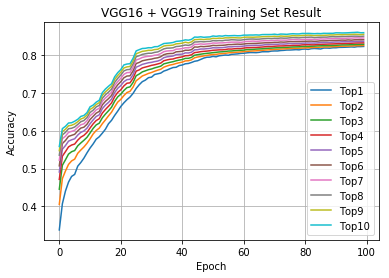

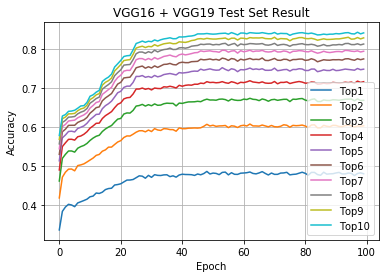

In [27]:
legends = []
for topn in topn_list:
    plt.plot(records[topn]["train"])
    legends.append("Top%d"%topn)
    
#     plt.plot(records[topn]["test"])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(legends)
plt.title("VGG16 + VGG19 Training Set Result")
plt.savefig("vgg16_vgg19_training_topn.png")
plt.show()

legends = []
for topn in topn_list:
    plt.plot(records[topn]["test"])
    legends.append("Top%d"%topn)
    
#     plt.plot(records[topn]["test"])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG16 + VGG19 Test Set Result")
plt.legend(legends)
plt.savefig("vgg16_vgg19_test_topn.png")
plt.show()

In [26]:
import pickle
with open("vgg16+vgg19_data.pkl","wb") as f:
    temp = {
        "net":net,
        "records":records
    }
    pickle.dump(temp,f)